### ASSIST tests: (5303) Parijskij encounter with Ceres.

Here we integrate the encounter of (5303) Parijskij with Ceres, using ASSIST.  

ASSIST and REBOUND together provide an ephemeris quality-integrator that has been compiled into a c library. The python version of ASSIST provides easy access to to this library.

ASSIST integrates massless test particles in the field of the Sun, planets, Moon, and 16 massive asteroids.  It also includes the J2, J3, and J4 gravitational harmonics of the Earth, the J2 gravitational harmonic of the Sun, and general relativistic correction terms for the Sun (using the PPN formulation).  

The positions of the massive bodies come from two binary files, both from JPL. The first is for the Sun, planets, and Moon, with the latest DE441 ephemeris. The other is for the asteroids, corresponding to DE441. Check the installation instructions on where to download those files. ASSIST will not work without those data files.

The coordinate frame and units are not flexible.  The coordinate frame is the equatorial International Celestial Reference System (ICRF), which is the native coordinate system for the JPL binary files. Note that this is equatorial rather than ecliptic. In addition, the native coordinates are barycentric, rather than heliocentric. 

For units we use solar masses, au, and days. The independent time coordinate is Barycentric Dynamical Time (TDB) in Julian days.

The underlying numerical integrator is IAS15 (Rein & Liu 2015), a 15th order predictor-corrector integrator with an adaptive step-size.  Each time step involves eight sub-steps. ASSIST provides a built-in support for interpolation between IAS15 timesteps.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import assist

au_km = 149597870.700



We start by loading the ephemeris data. Depending on where you've downloaded them, you might need to change the paths.

In [2]:
ephem = assist.Ephem("../data/de440.bsp", "../data/sb441-n16.bsp")

Next, we setup a REBOUND simulation, add the initial position of asteroid (5303) Parijskij. The units are astronomical units for the positions and astronomical units per day for the velocities.

In [3]:
sim = rebound.Simulation()
jpl_5303_start = rebound.Particle(
    x=-2.232847879711731E+00, y=1.574146331186095E+00, z=8.329414259670296E-01,
    vx=-6.247432571575564E-03, vy=-7.431073424167182E-03, vz=-3.231725223736132E-03)
sim.add(jpl_5303_start)

The following cell sets the initial simulation time. The above initial conditions are valid at JD 2449718.5 (1995-Jan-01). They are barycentric and equatorial.  In ASSIST, we measure time relative to the `jd_ref` parameter in the ephemeris structure.

In [4]:
t_initial = 2449718.5 - ephem.jd_ref # Julian Days relative to jd_ref
sim.t = t_initial


Now we attach assist to the simulation.

In [5]:
extras = assist.Extras(sim, ephem)

We can now integrate the system forward in time for 10 years (3653).

In [6]:
t_final = 2449718.5 + 3653.0 - ephem.jd_ref
N_samples = 3653
times = np.linspace(t_initial, t_final, N_samples, endpoint=True)

ast_5303 = np.zeros((N_samples, 3))
ceres = np.zeros((N_samples, 3))

for i, t in enumerate(times):
    extras.integrate_or_interpolate(t)
    ast_5303[i] = sim.particles[0].xyz
    ceres[i] = ephem.get_particle("ceres", t).xyz

The plots below shows the xy position of asteroid 5303 relative to Ceres around the time of the close encounter, along with the magnitude of the separation between the two bodies.

In [26]:
closest_index = np.argmin(np.linalg.norm(ast_5303[:,0:3]-ceres, axis=1))
dist_closest = np.linalg.norm(ast_5303[:,0:3]-ceres, axis=1)[closest_index]
t_closest = ephem.jd_ref+times[closest_index]

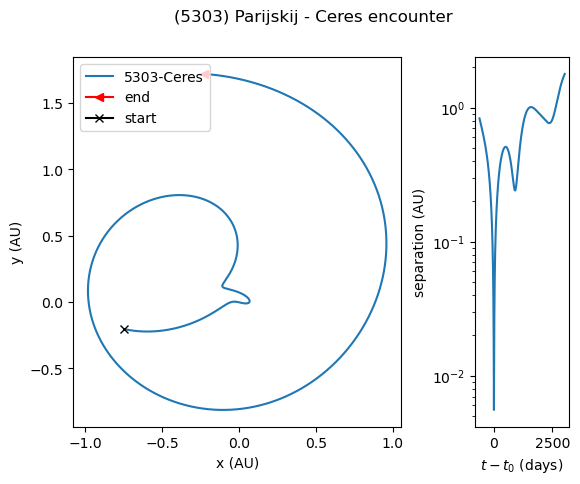

In [27]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.5, 1]})
fig.suptitle('(5303) Parijskij - Ceres encounter')

plt.subplots_adjust(wspace=0.35)
#fig.tight_layout()

axs[0].plot(ast_5303[:,0]-ceres[:,0], ast_5303[:,1]-ceres[:,1], label='5303-Ceres')
axs[0].plot(ast_5303[-1,0]-ceres[-1,0], ast_5303[-1,1]-ceres[-1,1], c='red', marker='<', label='end')
axs[0].plot(ast_5303[0,0]-ceres[0,0], ast_5303[0,1]-ceres[0,1], c='black', marker='x', label='start')
axs[0].legend()
axs[0].set_xlabel('x (AU)')
axs[0].set_ylabel('y (AU)')

axs[1].plot(times-times[closest_index], np.linalg.norm(ast_5303[:,0:3]-ceres, axis=1))
axs[1].set_yscale('log')
axs[1].set_xlabel('$t-t_{0}$ (days)')
axs[1].set_ylabel('separation (AU)')

plt.savefig('5303_Ceres_2panel.pdf')

In [25]:
print("The time of the closest approach is: JD %.6lf.  The approach is: %.6le AU.\n" % (t_closest, dist_closest))

The time of the closest approach is: JD 2450337.669496.  The approach is: 5.560704e-03 AU.

